# Import Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the Dataset

In [39]:
dataset = pd.read_csv('/content/ecg.csv',header=None)
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


# Split Data into Train,Valid,Test

In [40]:
dataset = dataset.values

labels = dataset[:, -1]

data = dataset[:, 0:-1]

data.shape , labels.shape

((4998, 140), (4998,))

In [41]:
split_size = int(len(data) * 0.5)

train_data = data[:split_size]
train_label = labels[:split_size]

valid_data = data[split_size:len(data)-1000]
valid_label = labels[split_size:len(data)-1000]

test_data = data[len(data)-1000:]
test_label = labels[len(data)-1000:]

train_data.shape,valid_data.shape,test_data.shape

((2499, 140), (1499, 140), (1000, 140))

In [42]:
def data_pipeline(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(1024)
    data = data.batch(32)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    return data

In [43]:
training_data = data_pipeline(train_data,train_label)
validation_data = data_pipeline(valid_data,valid_label)
testing_data = data_pipeline(test_data,test_label)

Text(0.5, 1.0, 'A Normal ECG')

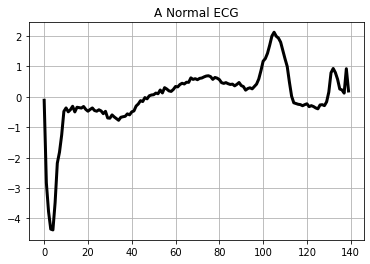

In [44]:
plt.grid()
plt.plot(np.arange(140), train_data[0],color='black',linewidth=3.0)
plt.title("A Normal ECG")

Text(0.5, 1.0, 'Abnormal ECG')

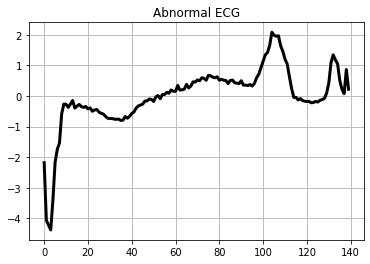

In [45]:
plt.grid()
plt.plot(np.arange(140), train_data[len(train_data)-1],color='black',linewidth=3.0)
plt.title("Abnormal ECG")

# Build The Model

In [54]:
class ECG_Classification_Model(tf.keras.Model):
    def __init__(self):
        super(ECG_Classification_Model, self).__init__()
        
        self.Lmda = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1))
        self.C1D = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')
        self.pool = tf.keras.layers.MaxPool1D(pool_size=2, strides=2)
        self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True))
        self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))
        self.batch = tf.keras.layers.BatchNormalization()
        self.flat = tf.keras.layers.Flatten()
        self.dns = tf.keras.layers.Dense(16, activation='relu')
        self.drop = tf.keras.layers.Dropout(0.2)
        self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self,inputs):
        x = inputs
        x = self.Lmda(inputs)
        x = self.C1D(x)
        x = self.pool(x)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.batch(x)
        x = self.flat(x)
        x = self.dns(x)
        x = self.drop(x)
        out = self.out(x)
        return out
    
    def build(self,shape=(140,)):
        inputs = tf.keras.layers.Input(shape=shape)
        return tf.keras.Model(inputs=[inputs], outputs=[self.call(inputs)])

In [62]:
model = ECG_Classification_Model()
model = model.build()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 140)]             0         
                                                                 
 lambda_3 (Lambda)           (None, 140, 1)            0         
                                                                 
 conv1d_3 (Conv1D)           (None, 136, 32)           192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 68, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_6 (Bidirectio  (None, 68, 64)           16640     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               2483

In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(0.1), metrics=["accuracy"])

In [64]:
history = model.fit(
    training_data,
    epochs=30,
    validation_data=validation_data,
    verbose=2,
)

Epoch 1/30
79/79 - 9s - loss: 0.1240 - accuracy: 0.9704 - val_loss: 0.9266 - val_accuracy: 0.4189 - 9s/epoch - 118ms/step
Epoch 2/30
79/79 - 1s - loss: 0.0492 - accuracy: 0.9892 - val_loss: 0.8039 - val_accuracy: 0.4189 - 1s/epoch - 17ms/step
Epoch 3/30
79/79 - 1s - loss: 0.0344 - accuracy: 0.9916 - val_loss: 0.7849 - val_accuracy: 0.4430 - 1s/epoch - 18ms/step
Epoch 4/30
79/79 - 1s - loss: 0.0365 - accuracy: 0.9920 - val_loss: 0.6296 - val_accuracy: 0.6991 - 1s/epoch - 18ms/step
Epoch 5/30
79/79 - 1s - loss: 0.0306 - accuracy: 0.9924 - val_loss: 0.4575 - val_accuracy: 0.8646 - 1s/epoch - 17ms/step
Epoch 6/30
79/79 - 1s - loss: 0.0218 - accuracy: 0.9948 - val_loss: 0.4941 - val_accuracy: 0.8866 - 1s/epoch - 18ms/step
Epoch 7/30
79/79 - 1s - loss: 0.0213 - accuracy: 0.9952 - val_loss: 0.3164 - val_accuracy: 0.9219 - 1s/epoch - 18ms/step
Epoch 8/30
79/79 - 1s - loss: 0.0198 - accuracy: 0.9956 - val_loss: 0.1962 - val_accuracy: 0.9473 - 1s/epoch - 17ms/step
Epoch 9/30
79/79 - 1s - loss: 0

<Figure size 432x288 with 0 Axes>

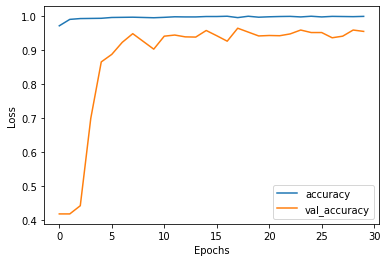

<Figure size 432x288 with 0 Axes>

In [66]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(range(len(history.history["accuracy"])), accuracy, '-')
plt.plot(range(len(history.history["val_accuracy"])), val_accuracy, '-')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["accuracy","val_accuracy"])
plt.figure()

In [65]:
accuracy = model.evaluate(testing_data)

32/32 [==============================] - 0s 9ms/step - loss: 0.1038 - accuracy: 0.9760


# Test The Model

In [67]:
prediction = model.predict(test_data)

32/32 [==============================] - 2s 8ms/step


Text(0.5, 1.0, 'Abnormal')

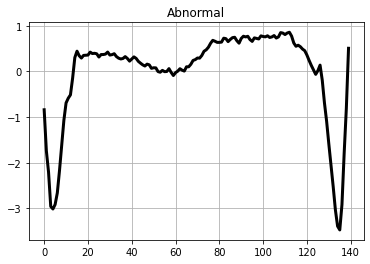

In [68]:
def prediction_label(num):
  return 'Normal' if num > 0.5 else 'Abnormal'

plt.grid()
plt.plot(np.arange(140), test_data[0],color='black',linewidth=3.0)
plt.title(prediction_label(prediction[0]))